In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import requests
from bs4 import BeautifulSoup
import itertools
from IPython.display import Markdown, display
from z3 import *

In [2]:
# Back to the first problem. Redoing withh Z3
url='https://www.janestreet.com/puzzles/travel-agent/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[6]+"\n\n"+str("\n".join(y[7:16]))))

### Travel Agent

Label a 6-sided die with your choice of integers between 1 and 9.   Also, label as many of the
empty
squares as you want in the below 12-by-12 grid with integers between 1 and 9.
Your goal is to create a die that can TRAVEL from 1 in the the upper-left corner of the board to the 1 in the lower-right corner of the board while generating the highest score you can.
The die must traverse a path of orthogonal steps between the two corners.  From step to step, the die “tips over” from one space to the neighboring space.  At each step, the number (face) pointing up on the die must match the number on the space.
You can choose the orientation for the INITIAL placement of the die in the upper-left corner, but after that, the die may not be re-oriented during its journey.  The die has to both start and finish with a “1” facing up, since it starts and ends on a “1” square.
Your path cannot revisit the same space twice.
Your score is the product of the numbers you visit along your path.
If you’ve got a solution, submit your score here, and send us a picture of your solution at travel-puzzle@janestreet.com !

### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2016/02/feb16_puzzle.png" width="350" >


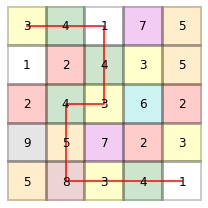

In [16]:
fixed = [[1, 5, 4, 4, 6, 1, 1, 4, 1, 3, 7, 5],
         [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [4, 0, 6, 4, 1, 8, 1, 4, 2, 1, 0, 3],
         [7, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2],
         [1, 0, 1, 0, 6, 1, 6, 2, 0, 2, 0, 1],
         [8, 0, 4, 0, 1, 0, 0, 8, 0, 3, 0, 5],
         [4, 0, 2, 0, 5, 0, 0, 3, 0, 5, 0, 2],
         [8, 0, 5, 0, 1, 1, 2, 3, 0, 4, 0, 6],
         [6, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 6],
         [3, 0, 6, 3, 6, 5, 4, 3, 4, 5, 0, 1],
         [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
         [2, 1, 6, 6, 4, 5, 2, 1, 1, 1, 7, 1]]

example= [[3, 4, 1, 7, 5],
          [1, 2, 4, 3, 5],
          [2, 4, 3, 6, 2],
          [9, 5, 7, 2, 3],
          [5, 8, 3, 4, 1]]

path= [0,5,10,11,12,7,8,9,14,19,24]
                  
                  
def grid_print(grid,path):
    fig,ax = plt.subplots(1,1,figsize=(3,3))    
    text = np.array(grid).astype('int').astype('str')
    text[text=="0"] == ""              
    ax =sns.heatmap(grid,annot=text,cbar=False,cmap=ListedColormap(["w","r","yellow","green","orange","c","m","brown","grey","hotpink"],N=np.max(grid)),fmt="",
                    linewidths=2,linecolor="k",annot_kws={"size":12,"color":"k"},alpha=.2)
    ax.tick_params(left=False, bottom=False,labelleft=False, labelright=True)
    xpoints = [i //len(grid)+0.5 for i in path]
    ypoints = [i % len(grid)+0.5 for i in path]
    plt.plot(xpoints,ypoints,"r")
    plt.axis("off")
    plt.tight_layout()
    plt.show()   
                  
                  
grid_print(example,path)                  

In [65]:
def solve_grid(grid):
    start = time.time()
    n =  len(grid)
    
    # set up Dice,Path,Matrix
    D = [Int("D_%s" % (i+1)) for i in range(6)]
    P = [Int("P_%s" % (i+1)) for i in range(n**2)]
    M = [Int("M_%s" % (i+1)) for i in range(n**2)]
    
    
    
    
    # set up the solver
    s = Optimize()
    
    # fix the dice for the example
    dice = [3,4,4,8,1,5]
    s += [D[i] == dice[i] for i in range(6)]
    
    # limit the dice and move values
    s += [And(d>0,d<=int(np.max(grid))) for d in D]
    s += [And(p >=0, p % n < n,p/n < n) for p in P]
    
    # no revisiting old cells
    s += Distinct([p for p in P[:-1]])
    s += [Implies(P[i-1]==n**2-1,P[i]==n**2-1) for i in range(1,n**2)]
    
    #can only move to neighbours
    moves = [(-1,0),(0,-1),(1,0),(0,1)]
    s += [Or([And(P[i] % n - P[i-1] % n == x,P[i] / n - P[i-1] / n == y) for x,y in moves]) for i in range(1,n**2)]
    
    
    s += P[0] == 0
    s += P[-1] == n**2-1
    
    if s.check() == sat:
        m = s.model()
        p = [m.evaluate(P[i]).as_long() for i in range(n**2)]
        d = [m.evaluate(D[i]).as_long() for i in range(6)]
        print("Solved in {:.2f} seconds".format(time.time()-start))
        grid_print(grid,p)
        print("Dice is :",d)
    else:
        print("failed to solve")  
  

Solved in 1.25 seconds


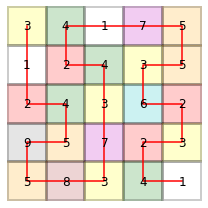

Dice is : [3, 4, 4, 8, 1, 5]


In [66]:
solve_grid(example)

In [ ]:
url='https://www.janestreet.com/puzzles/solutions/february-2016-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

display(Markdown("### Solution"))

display(Markdown("\n".join(x[7:11])))


<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2016/03/feb16_puzzle_solution_trimmed.png" width="400">
